In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import celerite as celery
import exoplanet as xo
np.random.seed(42)
%matplotlib inline

In [2]:
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP

#### Try fitting a GP to a short timeseries of single-mode RV oscillations:

In [3]:
d = np.genfromtxt('sim_oneyear_onemode.csv', names=True, dtype=None, delimiter=',')
ts_onemode = np.copy(d['ts'])
rvs_onemode = np.copy(d['rvs'])
xs_onemode = np.copy(d['xs'])

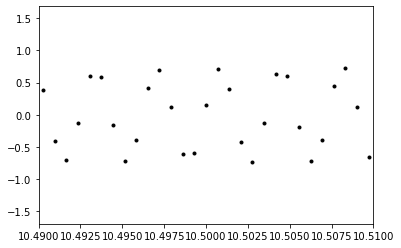

In [4]:
plt.plot(ts_onemode/86400., rvs_onemode, 'k.')
plt.xlim([10.49,10.51]);

In [5]:
inds = (ts_onemode > 10.49 * 86400) & (ts_onemode < 10.51 * 86400)
t = ts_onemode[inds]
y = rvs_onemode[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(t[0], t[-1], 1000)
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
132it [00:00, 273.93it/s, logp=7.609279e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: 32.259569351810896 -> 76.09279191086408


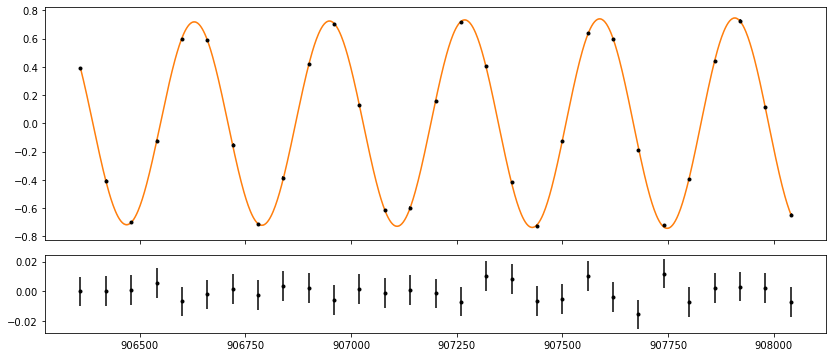

In [6]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
ax1.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")

# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".k", capsize=0, label="resids");

In [7]:
map_soln

{'logS0': array(-7.61159922),
 'logw0': array(-3.92939734),
 'logQ': array(9.86272682)}

This isn't quite what we expected - our calculation from `harmonic-oscillator.ipynb` was:
```
log_S0: -9.33721059
log_Q: 8.13423472
log_omega0: -3.92565541
```
BUT we do have an amplitudes issue when actually generating RVs from a GP with the above kernel and comparing to the RVs that we're using here, so maybe our expected logS0 is incorrect anyway.

#### Try with multi-mode RVs:

In [8]:
d = np.genfromtxt('sim_oneyear.csv', names=True, dtype=None, delimiter=',')
ts_multimode = np.copy(d['ts'])
rvs_multimode = np.copy(d['rvs'])
xs_multimode = np.copy(d['xs'])

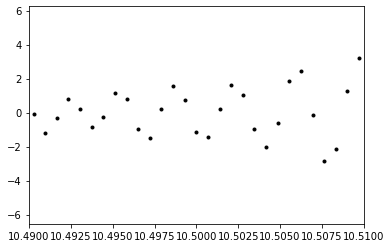

In [9]:
plt.plot(ts_multimode/86400., rvs_multimode, 'k.')
plt.xlim([10.49,10.51]);

In [10]:
inds = (ts_multimode > 10.49 * 86400) & (ts_multimode < 10.51 * 86400)
t = ts_multimode[inds]
y = rvs_multimode[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(t[0], t[-1], 1000)
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
21it [00:00, 877.49it/s, logp=-1.431953e+01] 
message: Optimization terminated successfully.
logp: -153.67169156782754 -> -14.319532140086299


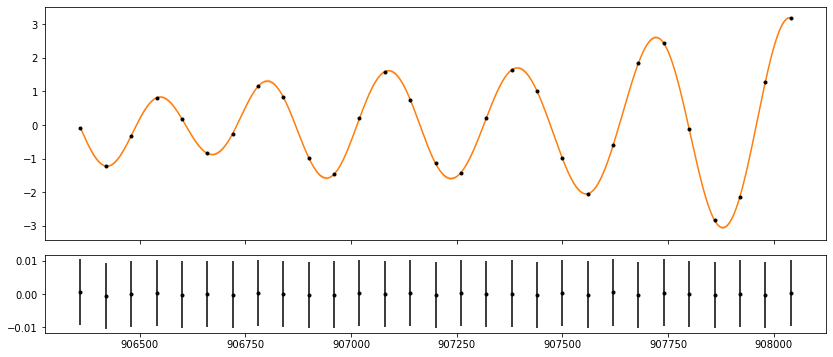

In [11]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
ax1.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")

# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".k", capsize=0, label="resids");

In [12]:
map_soln

{'logS0': array(0.68131953),
 'logw0': array(-3.89281373),
 'logQ': array(5.32584365)}

This is also an excellent fit, even though we only used one mode. Maybe a single DDHO is a good approximation over short timescales - let's try a longer stretch.

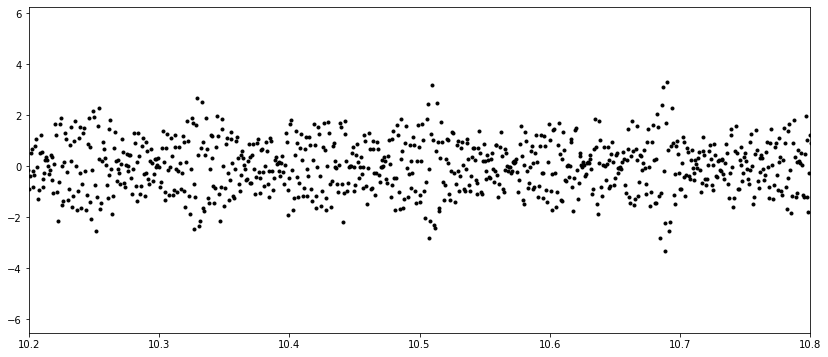

In [13]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(ts_multimode/86400., rvs_multimode, 'k.')
ax.set_xlim([10.2,10.8]);

In [14]:
inds = (ts_multimode > 10.2 * 86400) & (ts_multimode < 10.8 * 86400)
t = ts_multimode[inds]
y = rvs_multimode[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(t[0], t[-1], 1000)
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
35it [00:00, 816.04it/s, logp=4.205264e+01] 
message: Optimization terminated successfully.
logp: -3110.1602065641428 -> 42.052642349695056


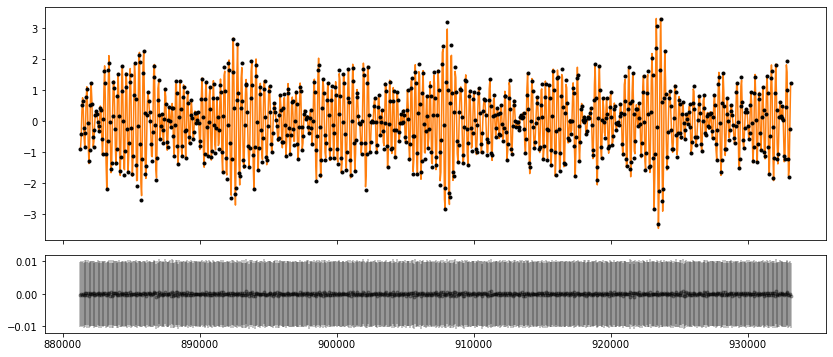

In [15]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
ax1.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")

# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".k", capsize=0, label="resids", alpha=0.3);